### 1. Loading Libraries & Eyeballing Pre-test data 

In [1]:
# To import rpy2 objects
# Load Libraries

import pandas as pd
from rpy2.robjects import packages, StrVector, IntVector, ListVector, r
from rpy2.robjects.packages import importr
#Import GeoLift, GeoLiftPlot and Convert functions
from utils import GeoLiftData, GeoLift, GeoLiftPlot, ConvertDf

In [2]:
pd_GeoLift_PreTest = pd.read_csv("GeoLift_PreTest.csv")
pd_GeoLift_PreTest.head()

,location,Y,date
0,new york,3300,2021-01-01
1,new york,3202,2021-01-02
2,new york,4138,2021-01-03
3,new york,3716,2021-01-04
4,new york,3270,2021-01-05


To show an end-to-end implementation of GeoLift we will use simulated data of 40
US cities across 90 days to: design a test, select test markets, run power calculations, and finally calculate the Lift caused by the campaign. As with every GeoLift test, we start analyzing pre-test historical information.

In [3]:
# Read the data into the proper format using the GeoDataRead Function

GeoLift_PreTest = ConvertDf(pd_GeoLift_PreTest, conv_type = "ToR")
print(GeoLift_PreTest.head())

  location    Y       date
0 new york 3300 2021-01-01
1 new york 3202 2021-01-02
2 new york 4138 2021-01-03
3 new york 3716 2021-01-04
4 new york 3270 2021-01-05
5 new york 3260 2021-01-06



Every GeoLift experiment should contain at least these three variables that reflect when, where, and how much of the KPI was measured. Nevertheless, if you have more data available, you can include covariates to GeoLift to improve our results through the X parameter of all GeoLift functions.

In [4]:
GeoTestData_PreTest = GeoLift.GeoDataRead(data = GeoLift_PreTest,
                                          date_id = "date",
                                          location_id = "location",
                                          Y_id = "Y",
                                          X = StrVector([]), #empty list as we have no covariates
                                          format = "yyyy-mm-dd",
                                          summary = True)

R[write to console]: ##################################
#####       Summary       #####
##################################

* Raw Number of Locations: 40
* Time Periods: 90
* Final Number of Locations (Complete): 40



Ensure that there are no missing value, or locations with missing time-stamps 

In [5]:
pd_GeoTestData_PreTest = ConvertDf(GeoTestData_PreTest, conv_type = "ToPandas")

pd_GeoTestData_PreTest.head()

,location,time,Y
1,atlanta,1,3384
2,atlanta,2,3904
3,atlanta,3,5734
4,atlanta,4,4311
5,atlanta,5,3686


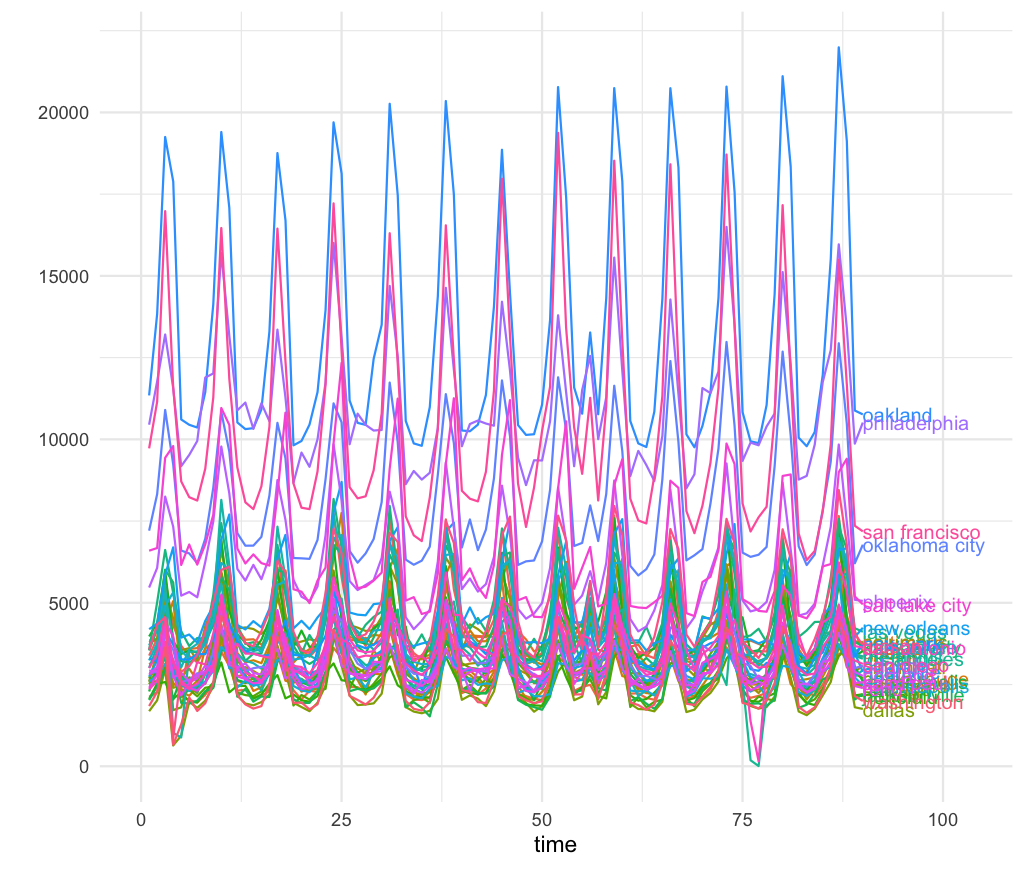

In [6]:
# Plot our Data with GeoPlot() it's good way to observe trends, detect anomalies before diving into data analysis

GeoLiftPlot(func = GeoLift.GeoPlot,
            data = GeoTestData_PreTest,
            Y_id = "Y",
            time_id = "time",
            location_id = "location")

In this case we see a similar pattern that’s shared across all locations. These structural similarities between regions are the key to a successful test!


### 2. Power Analysis 

What Power Analysis Help us uncover? 

- The optimal number of test locations.
- Best test duration.
- Select the ideal test and control markets.
- Get a good estimate of the budget needed to run the test.
- Determine which is the Minimum Detectable Effect to obtain significant results.
- Align expectations.

Through a series of simulations, this algorithm will find which are the best combinations of test and control locations for the experiment. Moreover, for each of these test market selections, the function will display the Minimum Detectable Effect, minimum investment needed to run a successful test, and other important model-fit metrics that will help us select the test that best matches our goals and resources.


In [7]:
# We are setting up our Analysis with two restrictions:
# Chicago must be part of the test markets and we have up to $100,000 to run the test.

MarketSelections = GeoLift.GeoLiftMarketSelection(data = GeoTestData_PreTest,
                                                  treatment_periods = IntVector([10,15]),
                                                  N = IntVector([2, 3, 4, 5]),
                                                  Y_id = "Y",
                                                  location_id = "location",
                                                  time_id = "time",
                                                  effect_size = r.seq(0, 0.5, 0.05),
                                                  lookback_window = 1, 
                                                  include_markets = StrVector(['chicago']),
                                                  exclude_markets = StrVector(['honolulu']),
                                                  holdout = IntVector([0.5,1]),
                                                  cpic = 7.50,
                                                  budget = 100000,
                                                  alpha = 0.1,
                                                  Correlations = True,
                                                  fixed_effects = True,
                                                  side_of_test = "two_sided")



R[write to console]: Setting up cluster.

R[write to console]: Importing functions into cluster.

R[write to console]: Attempting to load the environment ‘package:dplyr’

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Calculating which the best treatment groups are.

R[write to console]: 
Deterministic setup with 2 locations in treatment.

R[write to console]: 
Deterministic setup with 3 locations in treatment.

R[write to console]: 
Deterministic setup with 4 locations in treatment.

R[write to console]: 
Deterministic setup with 5 locations in treatment.



  ID                                           location duration EffectSize
1  1             chicago, cincinnati, houston, portland       15       0.05
2  2                                  chicago, portland       15       0.10
3  3             chicago, cincinnati, houston, portland       10       0.10
4  4                                  chicago, portland       10       0.10
5  5                         chicago, houston, portland       10       0.10
6  6 chicago, cincinnati, houston, nashville, san diego       15       0.05
  Power AvgScaledL2Imbalance Investment   AvgATT Average_MDE ProportionTotal_Y
1     1            0.1971864   74118.38 159.3627  0.04829913        0.07576405
2     1            0.1738778   64563.75 290.0071  0.10117316        0.03306537
3     1            0.1966996   99027.75 316.6204  0.09552879        0.07576405
4     1            0.1682310   43646.25 300.9401  0.10378013        0.03306537
5     1            0.2305628   75389.25 350.3142  0.10502968        0.057

### 2.1 Searching for the best Test Markets

In [8]:
# Visualize the best test markets converting the first position [0] of MarketSelections using ConvertDf().

MarketSelections_BestMarkets = ConvertDf(MarketSelections[0], conv_type = "ToPandas")

MarketSelections_BestMarkets.head()


,ID,location,duration,EffectSize,Power,AvgScaledL2Imbalance,Investment,AvgATT,Average_MDE,ProportionTotal_Y,abs_lift_in_zero,Holdout,rank,correlation
1,1,"chicago, cincinnati, houston, portland",15.0,0.05,1.0,0.197186,74118.375,159.362739,0.048299,0.075764,0.002,0.924236,1,0.914481
2,2,"chicago, portland",15.0,0.10,1.0,0.173878,64563.750,290.007081,0.101173,0.033065,0.001,0.966935,1,0.932110
3,3,"chicago, cincinnati, houston, portland",10.0,0.10,1.0,0.196700,99027.750,316.620350,0.095529,0.075764,0.004,0.924236,3,0.914481
4,4,"chicago, portland",10.0,0.10,1.0,0.168231,43646.250,300.940070,0.103780,0.033065,0.004,0.966935,3,0.932110
5,5,"chicago, houston, portland",10.0,0.10,1.0,0.230563,75389.250,350.314159,0.105030,0.057971,0.005,0.942029,5,0.913955


Results in MarketSelections show that the test markets with the best ranks are: (chicago, cincinnati, houston & portland) and (chicago, portland).

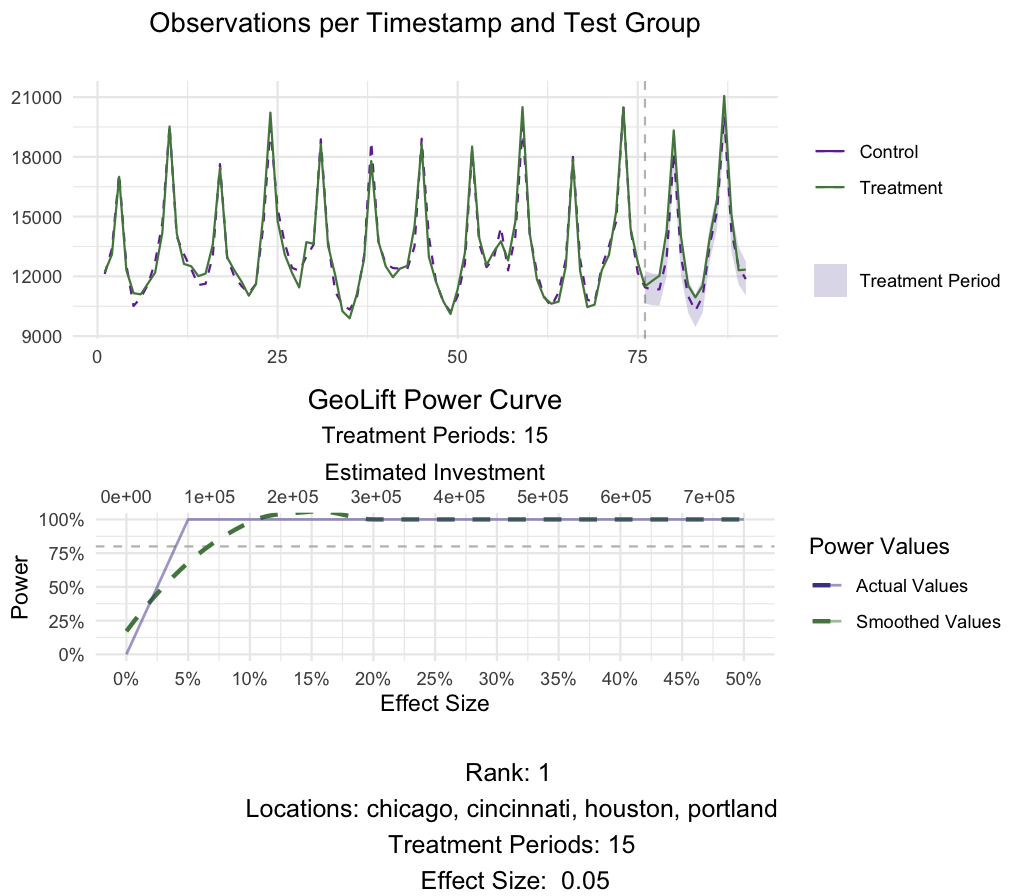

In [9]:
# Plot for Chicago, Cincinnati, Houston and Portland for a 15 day test
GeoLiftPlot(func = GeoLift.plot_GeoLiftMarketSelection,
            x = MarketSelections,
            market_ID = 1, 
            print_summary = False)

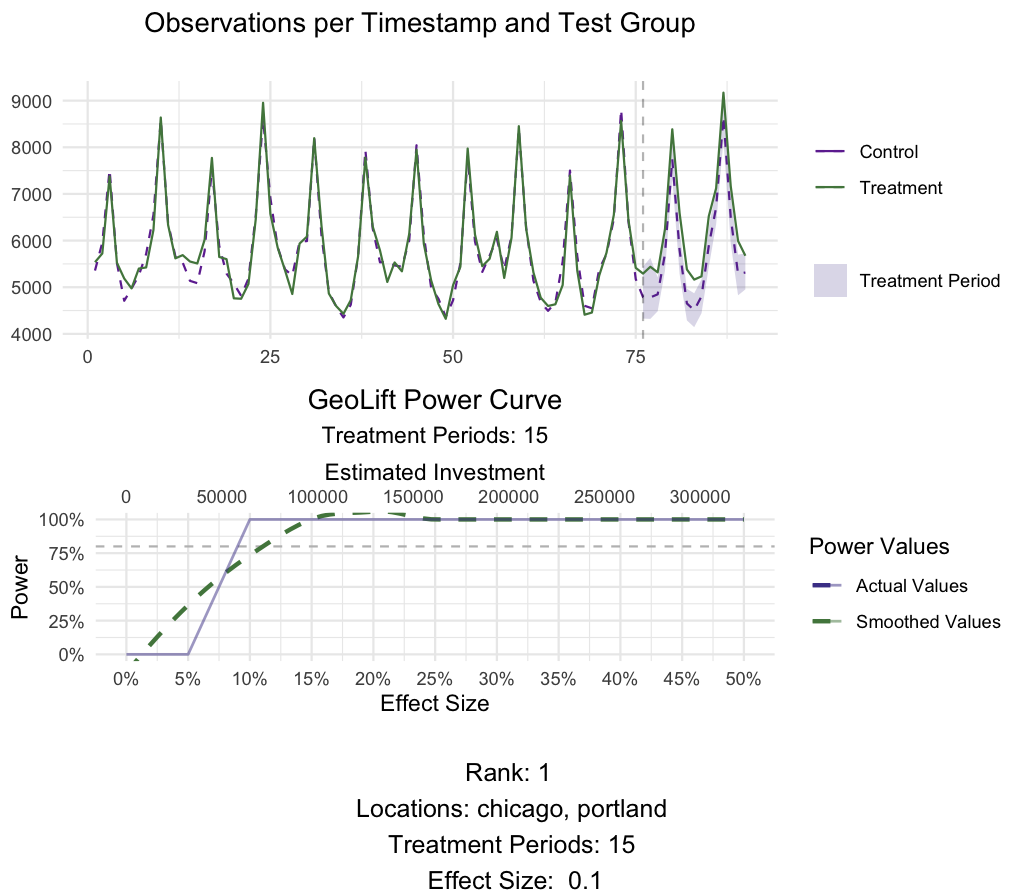

In [10]:
# Plot for chicago and portland for a 15 day test
GeoLiftPlot(func = GeoLift.plot_GeoLiftMarketSelection,
            x = MarketSelections,
            market_ID = 2, 
            print_summary = False)

In [11]:
power_data = GeoLift.GeoLiftPower(data = GeoTestData_PreTest,
                                    locations = StrVector(['chicago', 'portland']),
                                    effect_size = r.seq(-0.25, 0.25, 0.01),
                                    lookback_window = 10,
                                    treatment_periods = 15,
                                    cpic = 7.5,
                                    side_of_test = "two_sided")

R[write to console]: Setting up cluster.

R[write to console]: Importing functions into cluster.

R[write to console]: Calculating Power for the following treatment group: chicago; portland.



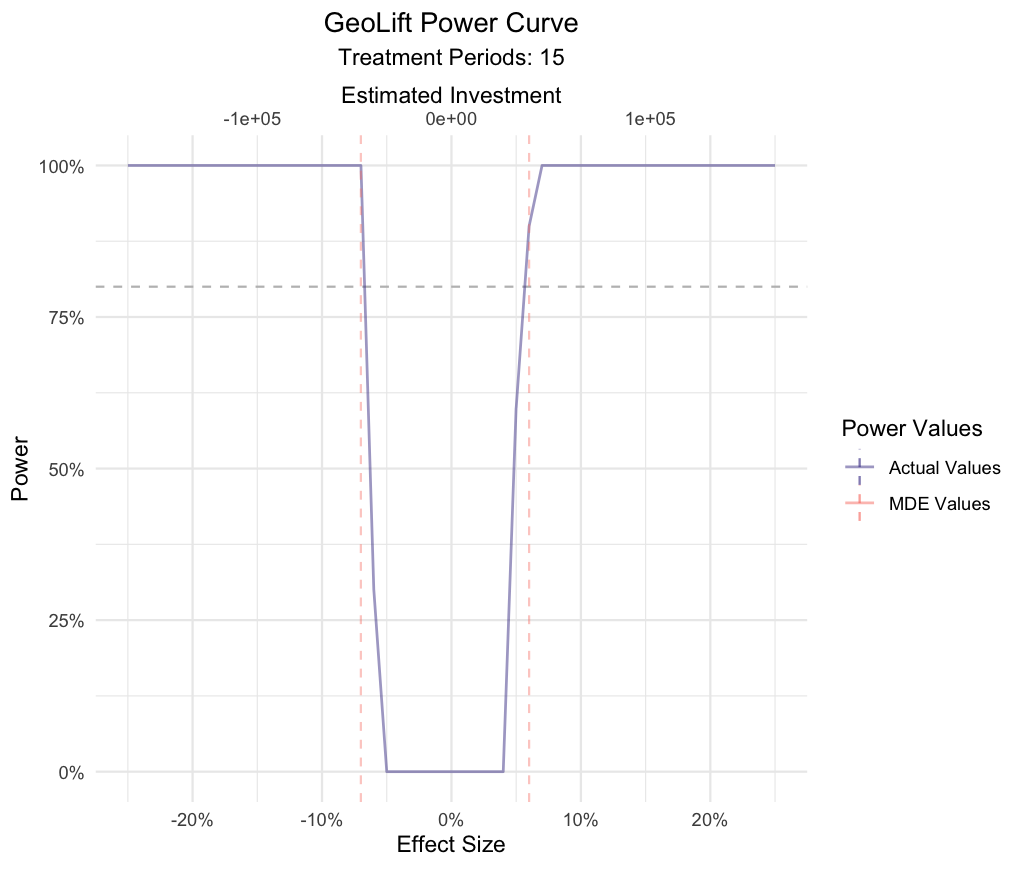

In [12]:
GeoLiftPlot(func = GeoLift.plot_GeoLiftPower,
            x = power_data, 
            show_mde = True, 
            smoothed_values = False, 
            breaks_x_axis = 5)    

While both market selections perform excellent on all metrics, we will move further with Chicago & Portland as they allows us to run a successful test with a smaller budget. Also, the power curve is symmetrical with respect to the y axis, it has no power when the true effect is zero, and has a similar behavior with more simulations. Finally, changing the print_summary parameter of GeoLiftPlot to True can provide us with additional information about this market selection.

In [13]:
weights = GeoLift.GetWeights(data = GeoTestData_PreTest,
                             Y_id = "Y",
                             location_id = "location",
                             time_id = "time",
                             locations = StrVector(['chicago', 'portland']),
                             pretreatment_end_time = 90,
                             fixed_effects = True)



R[write to console]: One outcome and one treatment time found. Running single_augsynth.



In [14]:
weights_pd = ConvertDf(df = weights, conv_type= "ToPandas")

# Top weights
weights_pd.sort_values(['weight'], axis=0, ascending=False).head()

,location,weight
6,cincinnati,0.227178
20,miami,0.202770
4,baton rouge,0.133537
22,minneapolis,0.089980
9,dallas,0.073923


### 3. Analyzing & Interpreting the Results 

Based on the results of the Power Calculations, a test is set-up in which a $65,000 and 15-day marketing campaign was executed in the cities of Chicago and Portland while the rest of the locations were put on holdout. Following the completion from this marketing campaign, we receive sales data that reflects these results. This new data-set contains the same format and information as the pre-test one but crucially includes results for the duration of the campaign. Depending on the vertical and product, adding a post-campaign cooldown period might be useful.

In [15]:
# Import our Test Data
pd_GeoLift_Test = pd.read_csv("GeoLift_Test.csv")
pd_GeoLift_Test.head()

,location,Y,date
0,new york,3300,2021-01-01
1,new york,3202,2021-01-02
2,new york,4138,2021-01-03
3,new york,3716,2021-01-04
4,new york,3270,2021-01-05


In [16]:
GeoLift_Test = ConvertDf(pd_GeoLift_Test, conv_type = "ToR")

print(GeoLift_Test.head())

  location    Y       date
0 new york 3300 2021-01-01
1 new york 3202 2021-01-02
2 new york 4138 2021-01-03
3 new york 3716 2021-01-04
4 new york 3270 2021-01-05
5 new york 3260 2021-01-06



In [17]:
GeoTestData_Test = GeoLift.GeoDataRead(data = GeoLift_Test,
                                       date_id = 'date',
                                       location_id = 'location',
                                       Y_id = 'Y',
                                       X = StrVector([]), #empty list as we have no covariates
                                       format = 'yyyy-mm-dd',
                                       summary = True)


R[write to console]: ##################################
#####       Summary       #####
##################################

* Raw Number of Locations: 40
* Time Periods: 105
* Final Number of Locations (Complete): 40



In [18]:
pd_GeoTestData_Test = ConvertDf(GeoTestData_Test, conv_type = "ToPandas")

pd_GeoTestData_Test.head()

,location,time,Y
1,atlanta,1,3384
2,atlanta,2,3904
3,atlanta,3,5734
4,atlanta,4,4311
5,atlanta,5,3686


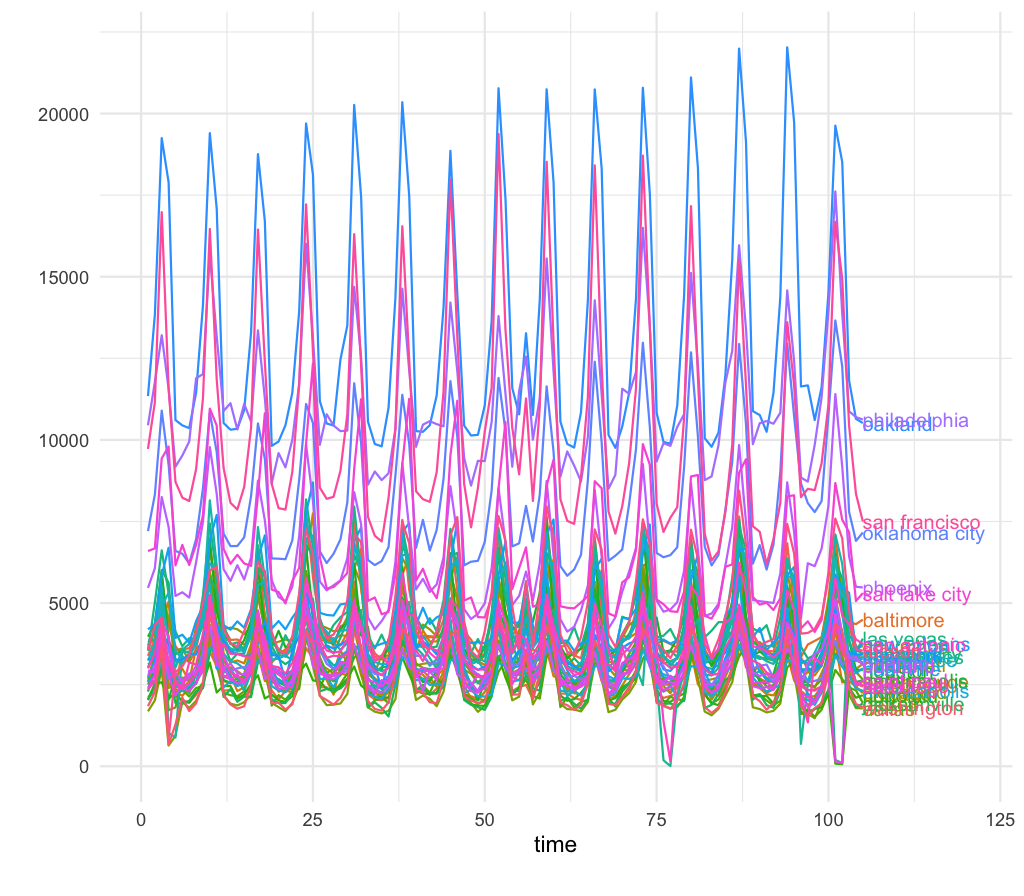

In [19]:
GeoLiftPlot(func = GeoLift.GeoPlot,
            data = GeoTestData_Test,
            Y_id = "Y",
            time_id = "time",
            location_id = "location")

The next step in the process is to calculate the actual Lift caused by the marketing campaigns on our test locations. 

In [20]:
GeoTest = GeoLift.GeoLift(Y_id = "Y",
                          data = GeoTestData_Test,
                          locations = StrVector(['chicago', 'portland']),
                          treatment_start_time = 91,
                          treatment_end_time = 105)

In [21]:
p = GeoLift.summary_GeoLift(GeoTest)
print(p)

R[write to console]: 
GeoLift Results Summary


R[write to console]: ##################################
#####     Test Statistics    #####
##################################

* Average ATT: 155.556
* Percent Lift: 5.4%
* Incremental Y: 4667
* P-value: 0.01

##################################
#####   Balance Statistics   #####
##################################

* L2 Imbalance: 909.489
* Scaled L2 Imbalance: 0.1636
* Percent improvement from naive model: 83.64%
* Average Estimated Bias: NA

##################################
#####     Model Weights      #####
##################################

* Prognostic Function: NONE

* Model Weights:

R[write to console]:  * cincinnati: 0.2272

R[write to console]:  * miami: 0.2028

R[write to console]:  * baton rouge: 0.1335

R[write to console]:  * minneapolis: 0.09

R[write to console]:  * dallas: 0.0739

R[write to console]:  * nashville: 0.0685

R[write to console]:  * honolulu: 0.0673

R[write to console]:  * austin: 0.0465

R[write to conso

R[write to console]: You can include dates in your chart if you supply the end date of the treatment. Just specify the treatment_end_date parameter.



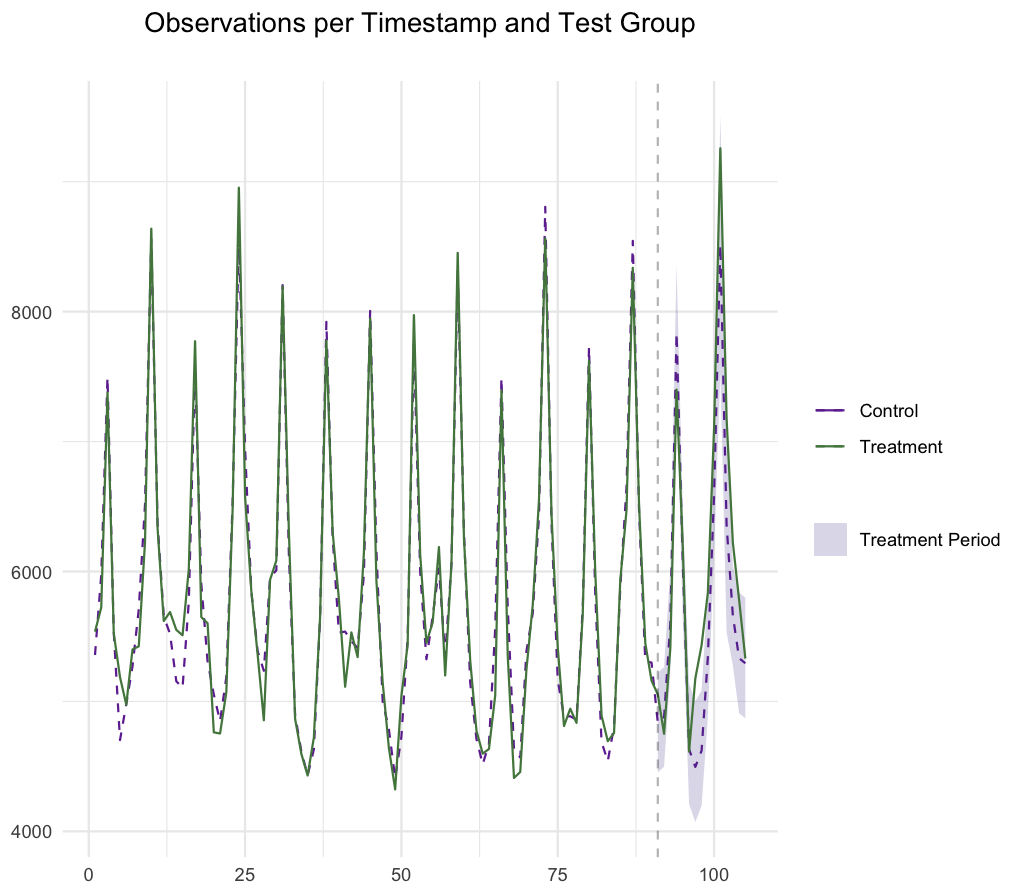

In [22]:
GeoLiftPlot(func = GeoLift.plot_GeoLift,
            x = GeoTest, 
            type = "Lift")

R[write to console]: You can include dates in your chart if you supply the end date of the treatment. Just specify the treatment_end_date parameter.



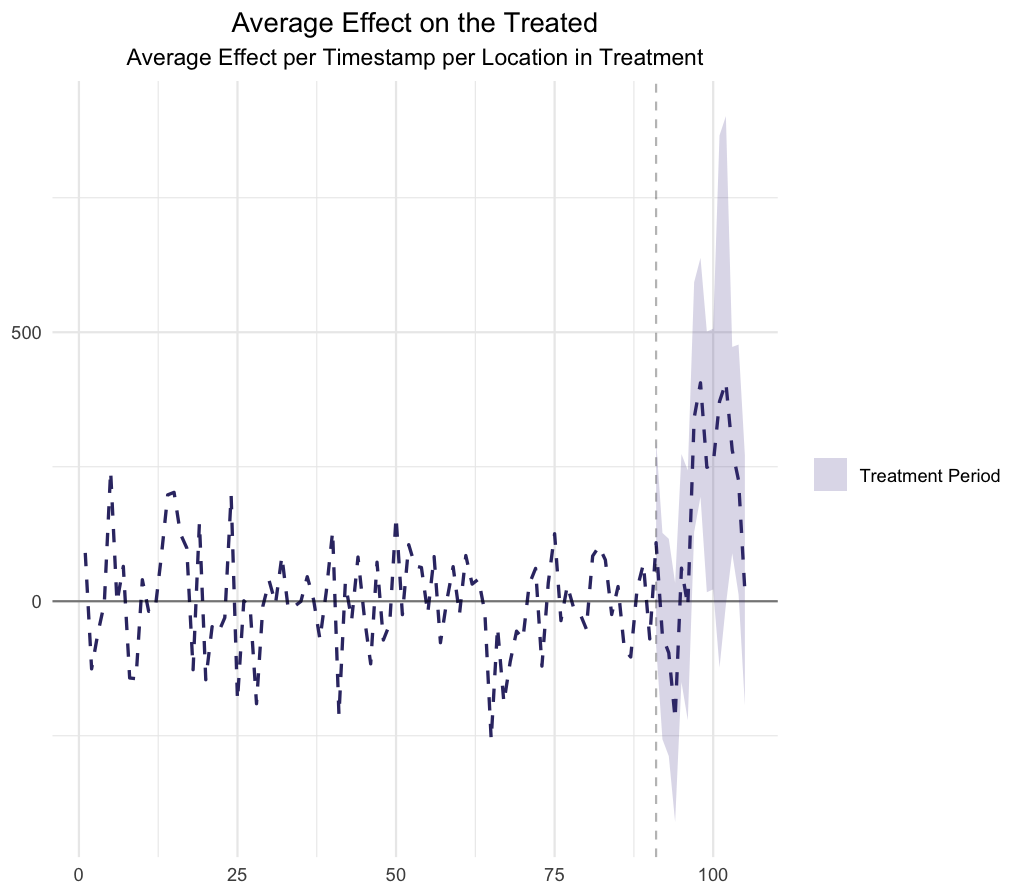

In [23]:
GeoLiftPlot(func = GeoLift.plot_GeoLift,
            x = GeoTest, 
            type = "ATT")

### 4. Improving The Model

In [24]:
GeoTestBest = GeoLift.GeoLift(Y_id = "Y",
                              data = GeoTestData_Test,
                              locations = StrVector(['chicago', 'portland']),
                              treatment_start_time = 91,
                              treatment_end_time = 105,
                              model = "best")

R[write to console]: Selected Ridge as best model.



In [25]:
p = GeoLift.summary_GeoLift(GeoTestBest)
print(p)

R[write to console]: 
GeoLift Results Summary


R[write to console]: ##################################
#####     Test Statistics    #####
##################################

* Average ATT: 156.805
* Percent Lift: 5.5%
* Incremental Y: 4704
* P-value: 0.01

##################################
#####   Balance Statistics   #####
##################################

* L2 Imbalance: 903.525
* Scaled L2 Imbalance: 0.1626
* Percent improvement from naive model: 83.74%
* Average Estimated Bias: -1.249

##################################
#####     Model Weights      #####
##################################

* Prognostic Function: RIDGE

* Model Weights:

R[write to console]:  * cincinnati: 0.2273

R[write to console]:  * miami: 0.2029

R[write to console]:  * baton rouge: 0.1337

R[write to console]:  * minneapolis: 0.0901

R[write to console]:  * dallas: 0.0741

R[write to console]:  * nashville: 0.0687

R[write to console]:  * honolulu: 0.0674

R[write to console]:  * austin: 0.0467

R[write t

R[write to console]: You can include dates in your chart if you supply the end date of the treatment. Just specify the treatment_end_date parameter.



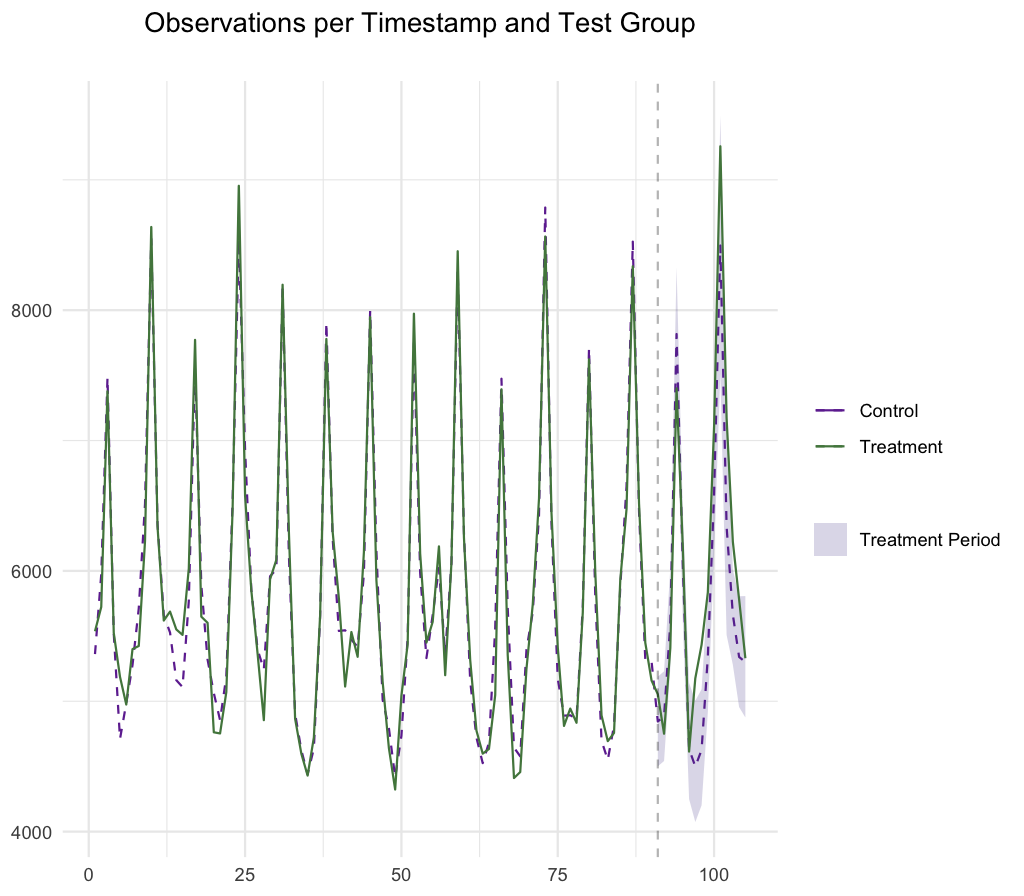

In [26]:
GeoLiftPlot(func = GeoLift.plot_GeoLift,
            x = GeoTestBest, 
            type = "Lift")

R[write to console]: You can include dates in your chart if you supply the end date of the treatment. Just specify the treatment_end_date parameter.



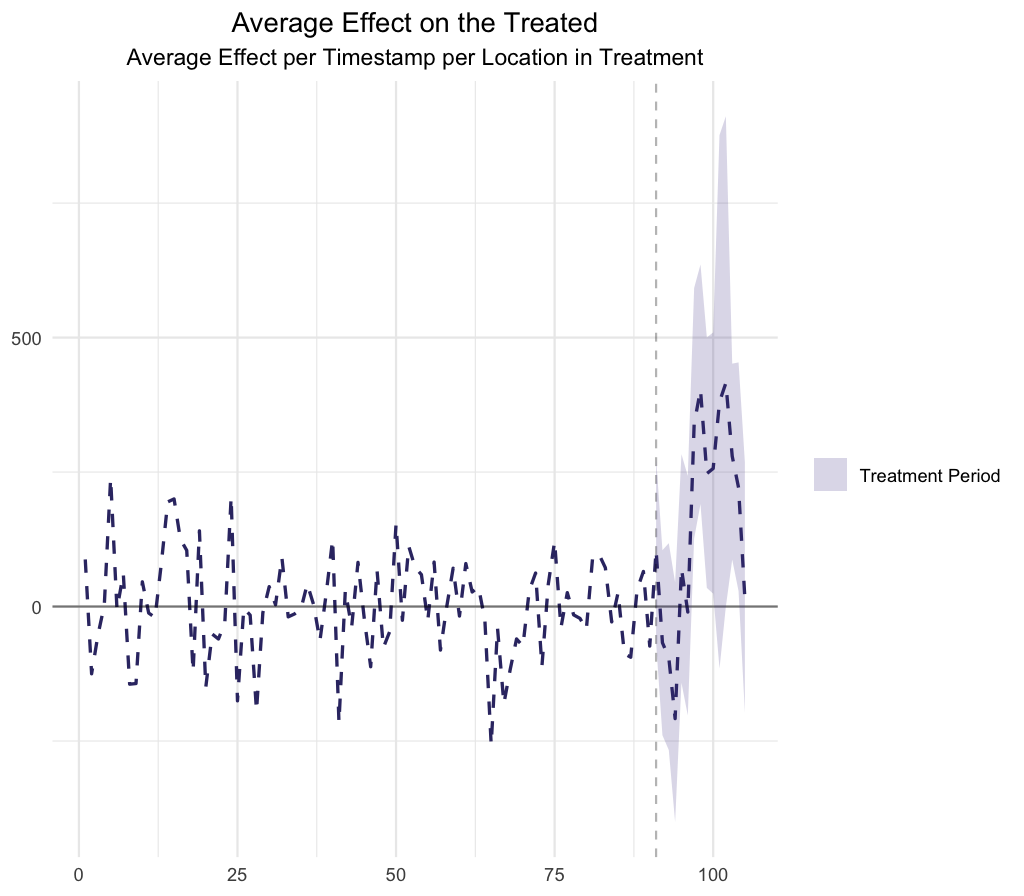

In [27]:
GeoLiftPlot(func = GeoLift.plot_GeoLift,
            x = GeoTestBest, 
            type = "ATT")

### Conclusion

The results show that the campaigns led to a 5.4% lift in units sold corresponding to 4667 incremental units for this 15-day test. Moreover, the Average Estimated Treatment Effect is of 155.556 units every day of the test. Most importantly, we observe that these results are statistically significant at a 95% level. In fact, there’s only a 1.1% chance of observing an effect of this magnitude or larger if the actual treatment effect was zero. In other words, it is extremely unlikely that these results are just due to chance. To dig deeper into the results, we can run the summary() of our GeoLift object.